In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import os
import cv2
random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset form drive

In [3]:
dataset_path = "/content/drive/MyDrive/rahat/animals"
animals = os.listdir(dataset_path)
print(animals)

['cats', 'dogs', 'panda']


Select 1000 images from each class for balanced dataset

In [4]:
selected_images = {}
for animal in animals:
  animal_path = os.path.join(dataset_path, animal)
  images = os.listdir(animal_path)
  if len(images) >= 3000:
    selected_images[animal] = random.sample(images, 3000)
  else:
    print(f"Class {animal} has less than 3000 images. Selecting all {len(images)} images.")
    selected_images[animal] = images

Class cats has less than 3000 images. Selecting all 1000 images.
Class dogs has less than 3000 images. Selecting all 1000 images.
Class panda has less than 3000 images. Selecting all 1000 images.


Initiating image properties and train_data size.

In [5]:
image_size = 32
images_count = 100
k_values = list(range(2, 20))

Suffile all 3000 images and randomly selecting **100** images to train

In [6]:
train_imgs = []

for index, animal in enumerate(animals):
    label = index
    path = os.path.join(dataset_path, animal)
    images = os.listdir(path)
    random.shuffle(images)

    for img in images[:images_count]:
        img_path = os.path.join(path, img)
        img_bgr = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.resize(img_gray, (image_size, image_size))
        train_imgs.append([img_gray, label])

np.random.shuffle(train_imgs)

Viewing the images with label to varify

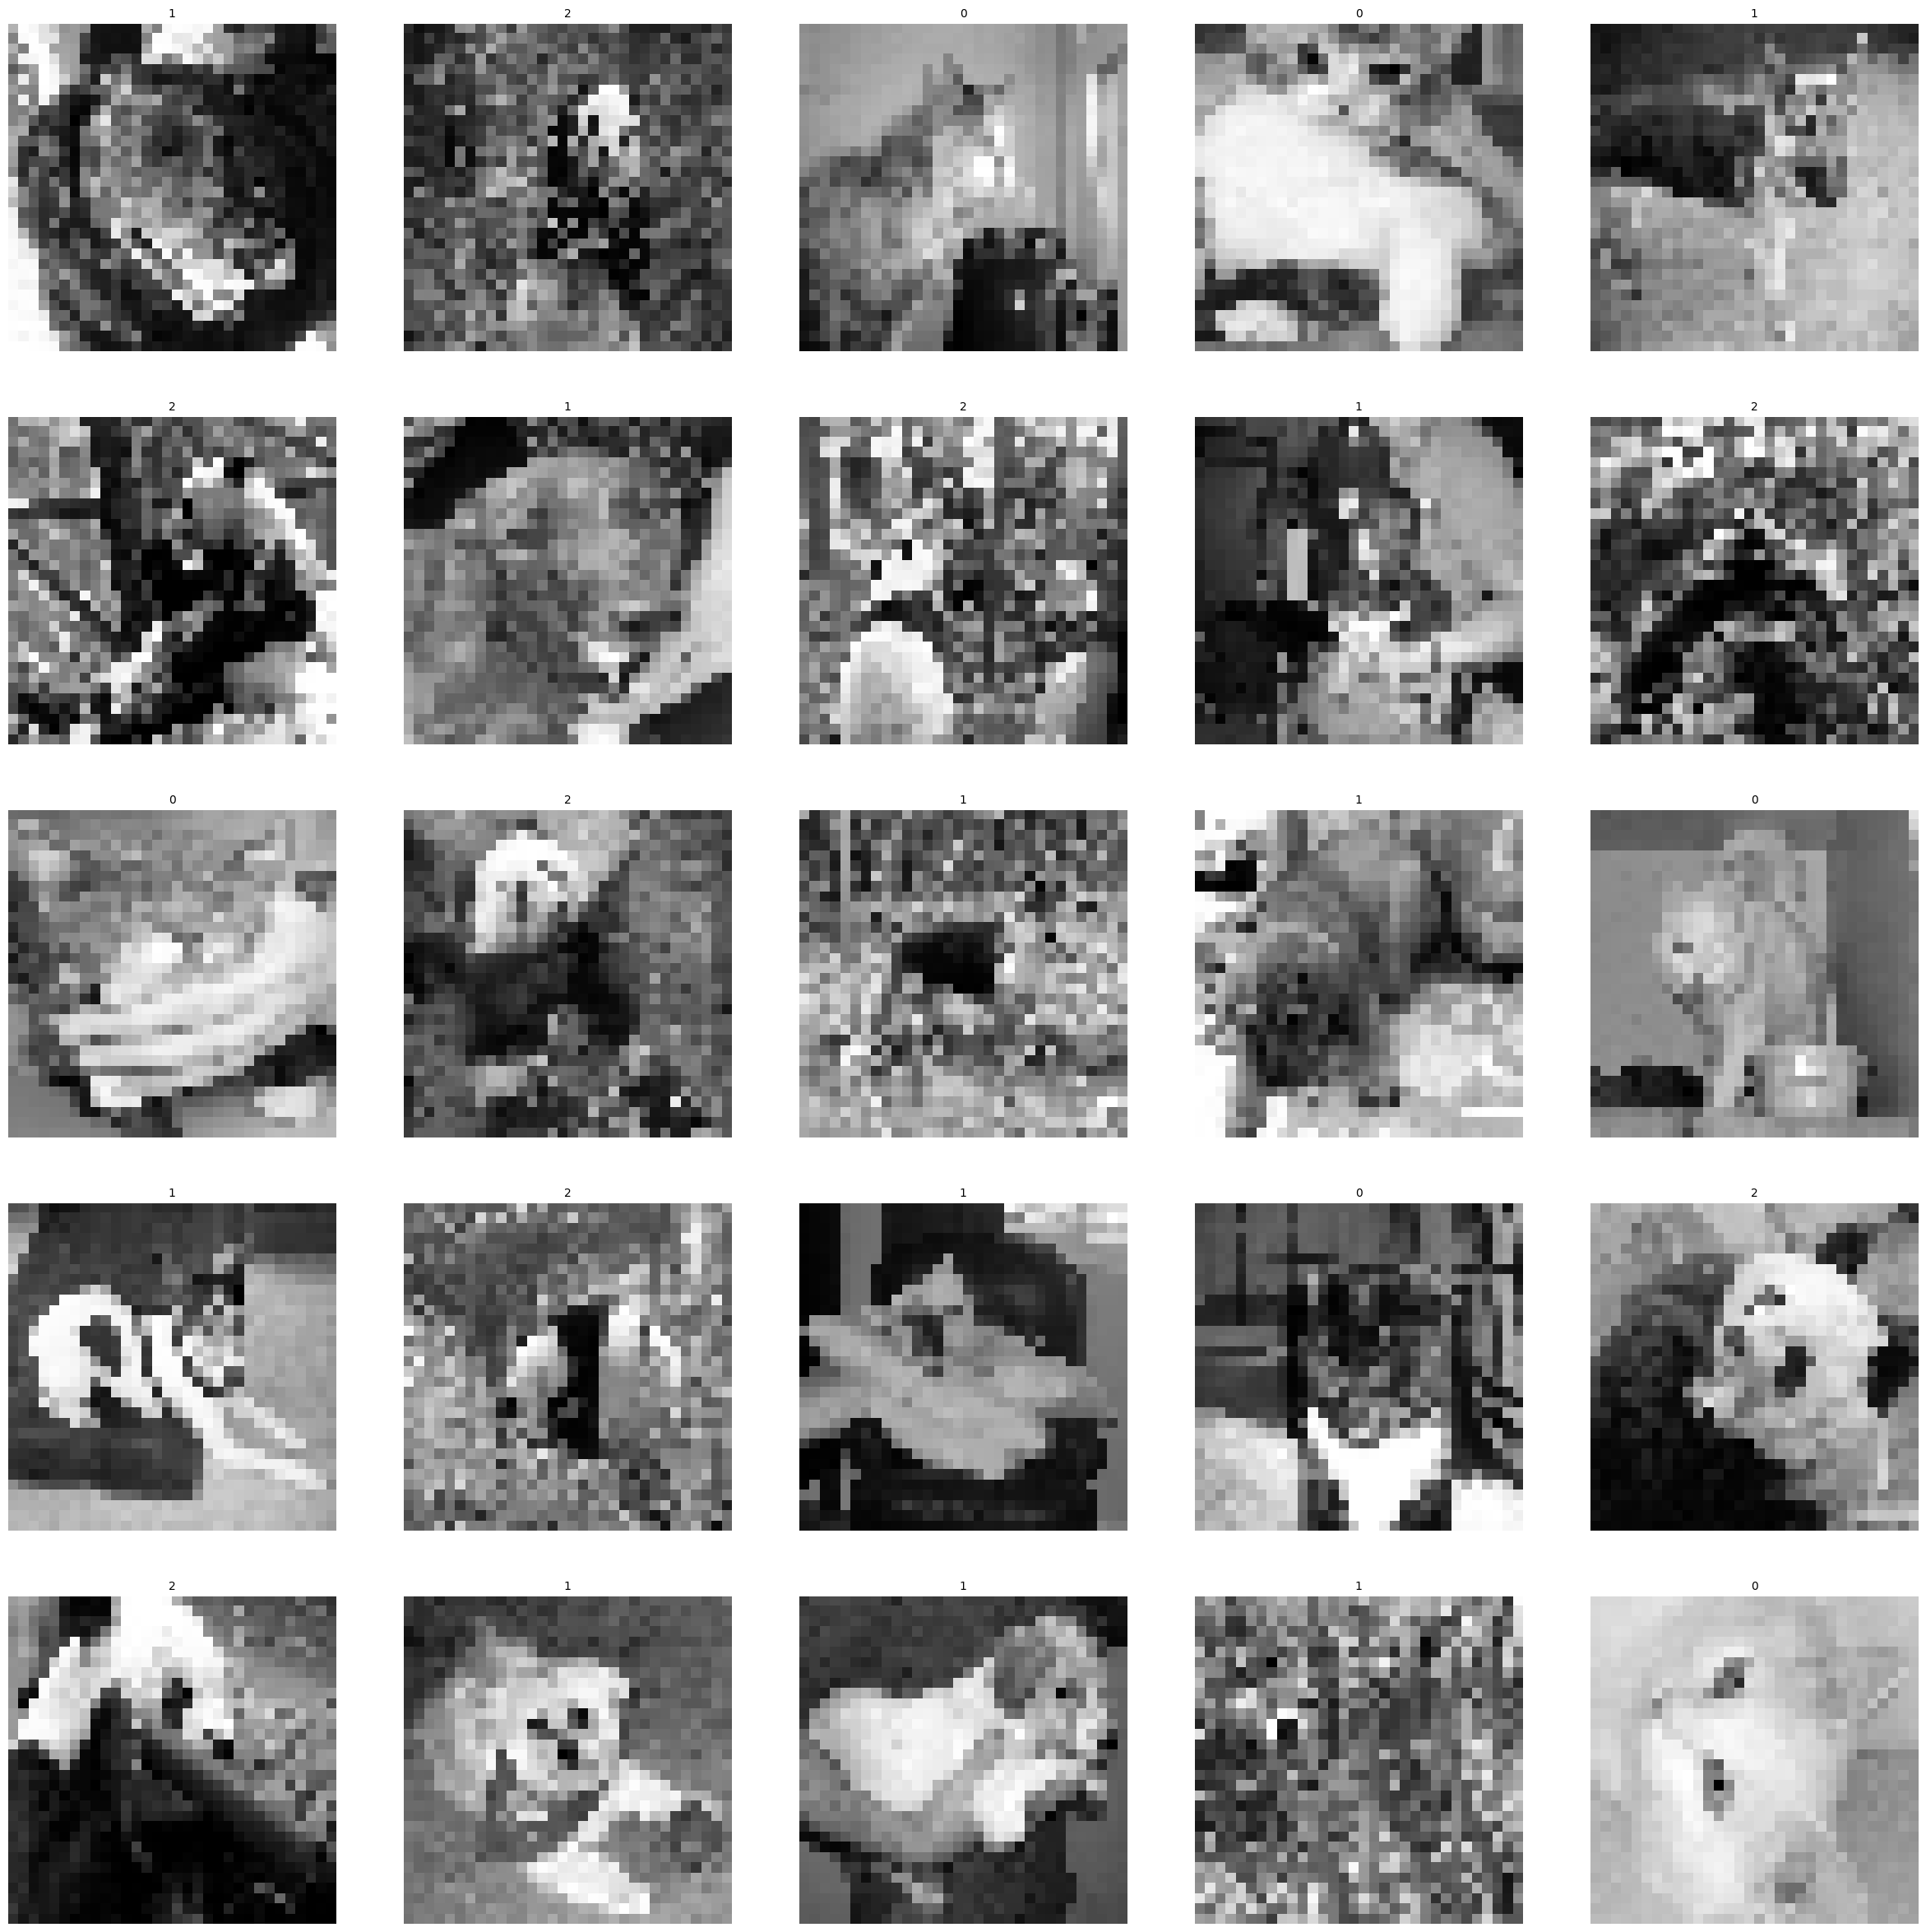

In [7]:
rows, cols = 5, 5
plt.figure(figsize=(30, 30))

for i in range(rows * cols):
    img, label = train_imgs[i]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=10)
    plt.axis('off')

plt.show()

Defining L1 and L2 distance functions

In [8]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [9]:
def predict(X_train, y_train, x_test, k, dist_func):
    distances = [dist_func(x_test, x) for x in X_train]
    nearest = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest]
    values, counts = np.unique(nearest_labels, return_counts=True)
    return values[np.argmax(counts)]

In [10]:
def cross_validation(X, Y, k_values, folds=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(X) // folds
    fold_indices = [indices[i*fold_size:(i+1)*fold_size] for i in range(folds)]

    accuracy_l1 = {k: [] for k in k_values}
    accuracy_l2 = {k: [] for k in k_values}

    for i in range(folds):
        val_idx = fold_indices[i]
        train_idx = np.hstack([fold_indices[j] for j in range(folds) if j != i])
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        for k in k_values:
            correct_l1 = correct_l2 = 0
            for x, y_true in zip(X_val, Y_val):
                pred_l1 = predict(X_train, Y_train, x, k, l1_distance)
                pred_l2 = predict(X_train, Y_train, x, k, l2_distance)
                correct_l1 += int(pred_l1 == y_true)
                correct_l2 += int(pred_l2 == y_true)
            accuracy_l1[k].append(correct_l1 / len(Y_val))
            accuracy_l2[k].append(correct_l2 / len(Y_val))
        print(f"Fold {i+1} completed.")

    avg_l1 = {k: np.mean(accuracy_l1[k]) for k in k_values}
    avg_l2 = {k: np.mean(accuracy_l2[k]) for k in k_values}
    return avg_l1, avg_l2

In [11]:
X = np.array([img[0].flatten() for img in train_imgs])
Y = np.array([img[1] for img in train_imgs])

avg_l1, avg_l2 = cross_validation(X, Y, k_values)

for k in k_values:
    print(f"Average Accuracy for k={k} (L1): {avg_l1[k]:.2f}")
    print(f"Average Accuracy for k={k} (L2): {avg_l2[k]:.2f}")

Fold 1 completed.
Fold 2 completed.
Fold 3 completed.
Fold 4 completed.
Fold 5 completed.
Average Accuracy for k=2 (L1): 0.38
Average Accuracy for k=2 (L2): 0.37
Average Accuracy for k=3 (L1): 0.36
Average Accuracy for k=3 (L2): 0.46
Average Accuracy for k=4 (L1): 0.39
Average Accuracy for k=4 (L2): 0.44
Average Accuracy for k=5 (L1): 0.37
Average Accuracy for k=5 (L2): 0.43
Average Accuracy for k=6 (L1): 0.38
Average Accuracy for k=6 (L2): 0.43
Average Accuracy for k=7 (L1): 0.39
Average Accuracy for k=7 (L2): 0.47
Average Accuracy for k=8 (L1): 0.40
Average Accuracy for k=8 (L2): 0.47
Average Accuracy for k=9 (L1): 0.39
Average Accuracy for k=9 (L2): 0.49
Average Accuracy for k=10 (L1): 0.39
Average Accuracy for k=10 (L2): 0.49
Average Accuracy for k=11 (L1): 0.40
Average Accuracy for k=11 (L2): 0.49
Average Accuracy for k=12 (L1): 0.39
Average Accuracy for k=12 (L2): 0.48
Average Accuracy for k=13 (L1): 0.41
Average Accuracy for k=13 (L2): 0.48
Average Accuracy for k=14 (L1): 0.40
A

Comparison between L1 and L2 distance

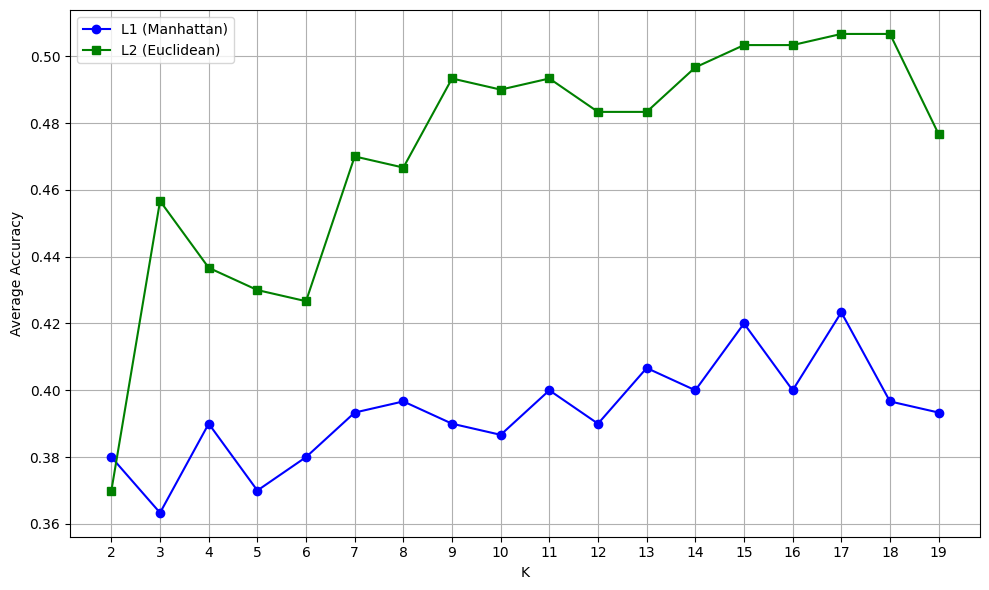

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(k_values, [avg_l1[k] for k in k_values], marker='o', label='L1 (Manhattan)', color='blue')
plt.plot(k_values, [avg_l2[k] for k in k_values], marker='s', label='L2 (Euclidean)', color='green')

plt.xlabel("K")
plt.ylabel("Average Accuracy")
plt.xticks(k_values)  # Ensure integer ticks on x-axis
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


From the graph, it's evident that the L2 (Euclidean) distance consistently outperforms the L1 (Manhattan) distance across most values of K in terms of average accuracy. The Euclidean method reaches its highest accuracy slightly above 0.50 at K = 17 and 18, indicating a more effective capture of feature similarity. In contrast, the Manhattan method achieves its peak accuracy of approximately 0.425 at K = 17, which is significantly lower.
The performance difference becomes more pronounced in the mid to higher range of K values (K = 7 to K = 18), where L2 maintains a stable and superior accuracy trend, whereas L1 fluctuates with smaller gains. This suggests that Euclidean distance is more sensitive to the overall magnitude of the data vectors, which may help capture spatial patterns or grayscale intensity variations in image data more effectively.
However, both metrics yield relatively low absolute accuracy values, indicating potential limitations in data preprocessing. The modest performance could be attributed to factors like lack of feature normalization, absence of dimensionality reduction, or not using optimized libraries such as scikit-learn that offer efficient and tuned implementations of KNN.


In [13]:
best_k_l1 = max(avg_l1, key=avg_l1.get)
best_k_l2 = max(avg_l2, key=avg_l2.get)

Showing the top 5 predictions

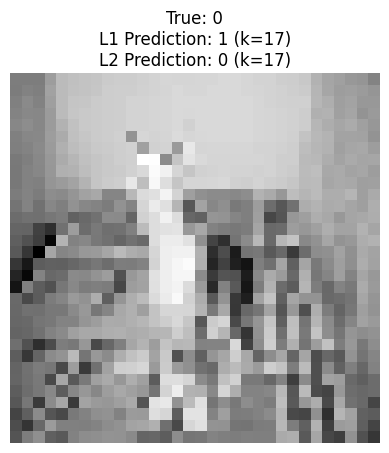

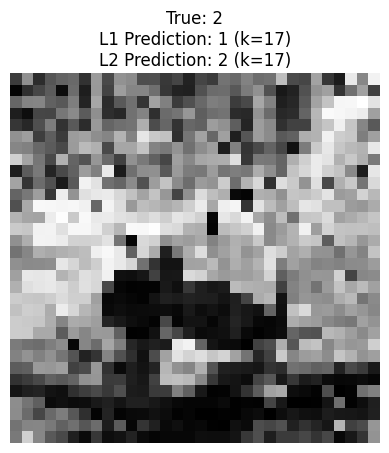

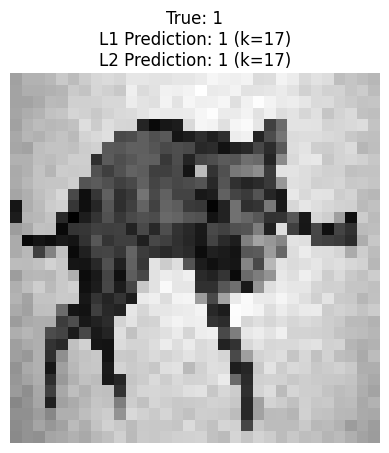

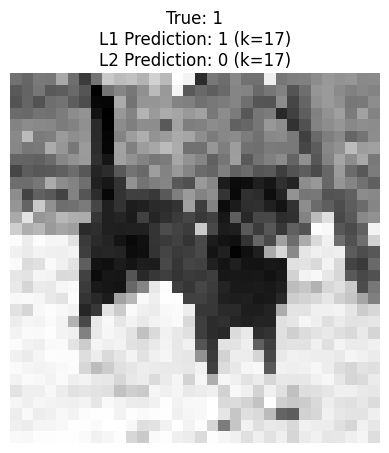

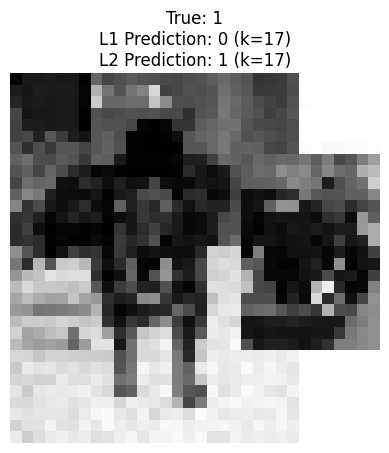

In [16]:
test_indices = random.sample(range(len(X)), 5)
X_test = X[test_indices]
Y_test = Y[test_indices]

for i, (x, true_label) in enumerate(zip(X_test, Y_test)):
    pred_l1 = predict(X, Y, x, k=best_k_l1, dist_func=l1_distance)
    pred_l2 = predict(X, Y, x, k=best_k_l2, dist_func=l2_distance)

    fig, ax = plt.subplots()
    ax.imshow(x.reshape(32, 32), cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True: {true_label}\n"
        f"L1 Prediction: {pred_l1} (k={best_k_l1})\n"
        f"L2 Prediction: {pred_l2} (k={best_k_l2})"
    )
    plt.show()

We see that based on the top five test predictions using k = 17, both L1 (Manhattan) and L2 (Euclidean) distance metrics achieved 60% accuracy, correctly classifying 3 out of 5 samples. While both metrics performed equally well in this small sample, L2 correctly predicted a sample that L1 missed and vice versa, highlighting some variability in individual predictions. However, when compared to the overall average accuracy across the dataset, L2 significantly outperforms L1, reaching a peak accuracy of 0.51 compared to L1's 0.42. This suggests that L2 is generally more reliable for capturing subtle variations in image features. The few misclassifications observed also point to potential improvements through preprocessing steps like normalization or by leveraging optimized libraries for KNN.